In [1]:
#Creating a spark session
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName("PySpark DataFrame and Sql").getOrCreate()

In [2]:
#Importing the data
df=spark.read.csv('/common_folder/nyc_parking/Parking_Violations_Issued_-_Fiscal_Year_2017.csv',header=True,inferSchema=True)

In [74]:
#Inspecting the dataframe
df.show(5)

+--------------+--------+------------------+-------------------+--------------+-----------------+------------+------------------+---------------+--------------+
|Summons Number|Plate ID|Registration State|         Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Violation Precinct|Issuer Precinct|Violation Time|
+--------------+--------+------------------+-------------------+--------------+-----------------+------------+------------------+---------------+--------------+
|    5092469481| GZH7067|                NY|2016-07-10 00:00:00|             7|             SUBN|       TOYOT|                 0|              0|         0143A|
|    5092451658| GZH7067|                NY|2016-07-08 00:00:00|             7|             SUBN|       TOYOT|                 0|              0|         0400P|
|    4006265037| FZX9232|                NY|2016-08-23 00:00:00|             5|             SUBN|        FORD|                 0|              0|         0233P|
|    8478629828| 66623ME|         

In [5]:
# Filtering data for 2017 year
from pyspark.sql.functions import col
df_2017 = df.filter(col("Issue Date").startswith("2017"))

In [76]:
df_2017.show(5)

+--------------+--------+------------------+-------------------+--------------+-----------------+------------+------------------+---------------+--------------+
|Summons Number|Plate ID|Registration State|         Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Violation Precinct|Issuer Precinct|Violation Time|
+--------------+--------+------------------+-------------------+--------------+-----------------+------------+------------------+---------------+--------------+
|    8478629828| 66623ME|                NY|2017-06-14 00:00:00|            47|             REFG|       MITSU|                14|             14|         1120A|
|    5096917368| FZD8593|                NY|2017-06-13 00:00:00|             7|             SUBN|       ME/BE|                 0|              0|         0852P|
|    1407740258| 2513JMG|                NY|2017-01-11 00:00:00|            78|             DELV|       FRUEH|               106|            106|         0015A|
|    1413656420|T672371C|         

In [3]:
df_2017.printSchema()

root
 |-- Summons Number: long (nullable = true)
 |-- Plate ID: string (nullable = true)
 |-- Registration State: string (nullable = true)
 |-- Issue Date: timestamp (nullable = true)
 |-- Violation Code: integer (nullable = true)
 |-- Vehicle Body Type: string (nullable = true)
 |-- Vehicle Make: string (nullable = true)
 |-- Violation Precinct: integer (nullable = true)
 |-- Issuer Precinct: integer (nullable = true)
 |-- Violation Time: string (nullable = true)



In [83]:
# Checking the missing data
print(df_2017.count())
df_2017.dropna(how='any').count()

5431918


5431918

None of the rows has any missing data

### Examining the data

In [84]:
# (1) Total number of tickets for the year
df_2017.count()

5431918

In [85]:
# (2) Number of unique states from where the cars that got parking tickets came
df_2017.select('Registration State').distinct().count()

65

In [6]:
# Checking the count of tickets state wise
from pyspark.sql.functions import col
examine_df=df_2017.cube('Registration State').count().sort(col('count').desc()).dropna()
examine_df.show()

+------------------+-------+
|Registration State|  count|
+------------------+-------+
|                NY|4273951|
|                NJ| 475825|
|                PA| 140286|
|                CT|  70403|
|                FL|  69468|
|                IN|  45525|
|                MA|  38941|
|                VA|  34367|
|                MD|  30213|
|                NC|  27152|
|                TX|  18827|
|                IL|  18666|
|                GA|  17537|
|                99|  16055|
|                AZ|  12379|
|                OH|  12281|
|                CA|  12153|
|                ME|  10806|
|                SC|  10395|
|                MN|  10083|
+------------------+-------+
only showing top 20 rows



<Figure size 3600x3600 with 0 Axes>

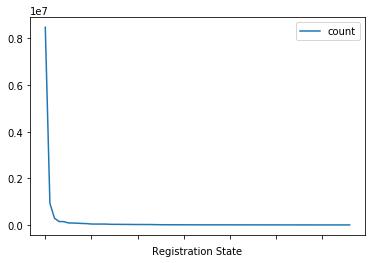

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(50,50))
plt.clf()
pdDF = examine_df.toPandas()
pdDF.plot(x='Registration State', y='count', kind='line', rot=45)
plt.show()

In [7]:
# Replacing the entry '99' by 'NY'
from pyspark.sql.functions import when

df_2017=df_2017.withColumn("Registration State1",\
                when(df_2017["Registration State"]=='99', 'NY').otherwise(df_2017['Registration State']))

In [88]:
examine_df=df_2017.cube('Registration State1').count().sort(col('count').desc()).dropna()
examine_df.show()

+-------------------+-------+
|Registration State1|  count|
+-------------------+-------+
|                 NY|4290006|
|                 NJ| 475825|
|                 PA| 140286|
|                 CT|  70403|
|                 FL|  69468|
|                 IN|  45525|
|                 MA|  38941|
|                 VA|  34367|
|                 MD|  30213|
|                 NC|  27152|
|                 TX|  18827|
|                 IL|  18666|
|                 GA|  17537|
|                 AZ|  12379|
|                 OH|  12281|
|                 CA|  12153|
|                 ME|  10806|
|                 SC|  10395|
|                 MN|  10083|
|                 OK|   9088|
+-------------------+-------+
only showing top 20 rows



In [89]:
# Checkin the unique states again
df_2017.select('Registration State1').distinct().count()

64

In [8]:
df_2017=df_2017.drop('Registration State')

In [91]:
df_2017.printSchema()

root
 |-- Summons Number: long (nullable = true)
 |-- Plate ID: string (nullable = true)
 |-- Issue Date: timestamp (nullable = true)
 |-- Violation Code: integer (nullable = true)
 |-- Vehicle Body Type: string (nullable = true)
 |-- Vehicle Make: string (nullable = true)
 |-- Violation Precinct: integer (nullable = true)
 |-- Issuer Precinct: integer (nullable = true)
 |-- Violation Time: string (nullable = true)
 |-- Registration State1: string (nullable = true)



### Aggregation Tasks

In [9]:
# (1) How often does each violation code occur? Display the frequency of the top five violation codes.
df_2017.createOrReplaceTempView("order_table")
spark.sql(""" SELECT `Violation Code`,count(`Violation Code`) as Frequency FROM order_table GROUP BY `Violation Code` ORDER BY Frequency desc""").show(5)

+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|            21|   768087|
|            36|   662765|
|            38|   542079|
|            14|   476664|
|            20|   319646|
+--------------+---------+
only showing top 5 rows



In [10]:
# (2) How often does each 'vehicle body type' get a parking ticket? How about the 'vehicle make'? 
print('For Body Type')
df_2017.cube('Vehicle Body Type').count().sort(col('count').desc()).dropna().show()

For Body Type
+-----------------+-------+
|Vehicle Body Type|  count|
+-----------------+-------+
|             SUBN|1883954|
|             4DSD|1547312|
|              VAN| 724029|
|             DELV| 358984|
|              SDN| 194197|
|             PICK| 135772|
|             2DSD| 135707|
|             REFG|  59641|
|             TRAC|  40030|
|             TAXI|  32608|
|             UTIL|  31135|
|              BUS|  24749|
|             4 DR|  24153|
|             CONV|  22064|
|              nan|  20201|
|             WAGO|  17465|
|               4D|  16647|
|             TRLR|  14281|
|              MCY|  12838|
|               TK|  11386|
+-----------------+-------+
only showing top 20 rows



In [11]:
print('For Make')
df_2017.cube('Vehicle Make').count().sort(col('count').desc()).dropna().show()

For Make
+------------+------+
|Vehicle Make| count|
+------------+------+
|        FORD|636844|
|       TOYOT|605291|
|       HONDA|538884|
|       NISSA|462017|
|       CHEVR|356032|
|       FRUEH|230787|
|       ME/BE|197568|
|       DODGE|187729|
|         BMW|186700|
|        JEEP|175815|
|       HYUND|148657|
|       INTER|128737|
|         GMC|127581|
|       LEXUS|122078|
|       ACURA|100637|
|       INFIN| 88572|
|       CHRYS| 85573|
|       VOLKS| 85051|
|       SUBAR| 71791|
|        AUDI| 68854|
+------------+------+
only showing top 20 rows



In [95]:
# (3) Violation Precinct and Issuer Precinct
df_2017.cube('Violation Precinct').count().sort(col('count').desc()).dropna().show(6)

#Ignore 0 precinct as this is erroneous

+------------------+------+
|Violation Precinct| count|
+------------------+------+
|                 0|925596|
|                19|274445|
|                14|203553|
|                 1|174702|
|                18|169131|
|               114|147444|
+------------------+------+
only showing top 6 rows



In [96]:
df_2017.cube('Issuer Precinct').count().sort(col('count').desc()).dropna().show(6)
#Ignore 0 precinct as this is erroneous

+---------------+-------+
|Issuer Precinct|  count|
+---------------+-------+
|              0|1078406|
|             19| 266961|
|             14| 200495|
|              1| 168740|
|             18| 162994|
|            114| 144054|
+---------------+-------+
only showing top 6 rows



In [97]:
# (4)Find the violation code frequencies for three precincts that have issued the most number of tickets. Do these precinct zones have an exceptionally high frequency of certain violation codes? Are these codes common across precincts?

# Top 3 issuer precincts are 19,14 and 1.(0 is an erroneous entry so ignoring it)

# Printing top 5 Violation Code frequencies for issuer precinct 19
print('Top 5 Violation Codes frequencies for issuer precinct 19')
spark.sql(""" SELECT `Violation Code`,count(`Violation Code`) as Frequency FROM order_table where `Issuer Precinct` = 19 GROUP BY `Violation Code` ORDER BY Frequency desc""").show(5)

Top 5 Violation Codes frequencies for issuer precinct 19
+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|            46|    48445|
|            38|    36386|
|            37|    36056|
|            14|    29797|
|            21|    28415|
+--------------+---------+
only showing top 5 rows



In [98]:
# Printing top 5 Violation Code frequencies for issuer precinct 14
print('Top 5 Violation Codes frequencies for issuer precinct 14')
spark.sql(""" SELECT `Violation Code`,count(`Violation Code`) as Frequency FROM order_table where `Issuer Precinct` = 14 GROUP BY `Violation Code` ORDER BY Frequency desc""").show(5)

Top 5 Violation Codes frequencies for issuer precinct 14
+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|            14|    45036|
|            69|    30464|
|            31|    22555|
|            47|    18364|
|            42|    10027|
+--------------+---------+
only showing top 5 rows



In [99]:
# Printing top 5 Violation Code frequencies for issuer precinct 1
print('Top 5 Violation Codes frequencies for issuer precinct 1')
spark.sql(""" SELECT `Violation Code`,count(`Violation Code`) as Frequency FROM order_table where `Issuer Precinct` = 1 GROUP BY `Violation Code` ORDER BY Frequency desc""").show(5)

Top 5 Violation Codes frequencies for issuer precinct 1
+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|            14|    38354|
|            16|    19081|
|            20|    15408|
|            46|    12745|
|            38|     8535|
+--------------+---------+
only showing top 5 rows



In [ ]:
# Some conclusions drawn from above results
#1. 14 violation code is common for all three issuer precincts.
#2. For issuer precinct 19, 46 violation code has exceptionally high frequency of 48445.
#3. For issuer precinct 14 and 1, 14 violation code has exceptionally high frequency of ~3800 - 45000

In [100]:
#5.Find out the properties of parking violations across different times of the day

# No null values present in Violation Time column

#PySpark version 
df_2017.filter(col('Violation Time').isNull()).count()

# SQL code
spark.sql(""" SELECT count(`Violation time`) FROM order_table where `Violation Time` is null""").show()

+---------------------+
|count(Violation time)|
+---------------------+
|                    0|
+---------------------+



In [12]:
# Dividing data frame into 6 time inervals namely 12AM-3AM,4AM-7AM,8AM-11AM,12PM-3PM,4PM-7PM,8PM-11PM
df_2017 = df_2017.withColumn("Hour Bin",
       when((col("Violation Time").startswith("00") | col("Violation Time").startswith("01") | col("Violation Time").startswith("02") | col("Violation Time").startswith("03")) & (col("Violation Time").endswith("A")), "12AM-3AM")
      .when((col("Violation Time").startswith("04") | col("Violation Time").startswith("05") | col("Violation Time").startswith("06") | col("Violation Time").startswith("07")) & (col("Violation Time").endswith("A")), "4AM-7AM")
      .when((col("Violation Time").startswith("08") | col("Violation Time").startswith("09") | col("Violation Time").startswith("10") | col("Violation Time").startswith("11")) & (col("Violation Time").endswith("A")), "8AM-11AM")
      .when((col("Violation Time").startswith("12") | col("Violation Time").startswith("01") | col("Violation Time").startswith("02") | col("Violation Time").startswith("03")) & (col("Violation Time").endswith("P")), "12PM-3PM")
      .when((col("Violation Time").startswith("04") | col("Violation Time").startswith("05") | col("Violation Time").startswith("06") | col("Violation Time").startswith("07")) & (col("Violation Time").endswith("P")), "4PM-7PM")
      .when((col("Violation Time").startswith("08") | col("Violation Time").startswith("09") | col("Violation Time").startswith("10") | col("Violation Time").startswith("11")) & (col("Violation Time").endswith("P")), "8PM-11PM")
      .otherwise("NA"))

In [13]:
df_2017.createOrReplaceTempView("order_table")

In [103]:
spark.sql("""describe order_table""").show()

+-------------------+---------+-------+
|           col_name|data_type|comment|
+-------------------+---------+-------+
|     Summons Number|   bigint|   null|
|           Plate ID|   string|   null|
|         Issue Date|timestamp|   null|
|     Violation Code|      int|   null|
|  Vehicle Body Type|   string|   null|
|       Vehicle Make|   string|   null|
| Violation Precinct|      int|   null|
|    Issuer Precinct|      int|   null|
|     Violation Time|   string|   null|
|Registration State1|   string|   null|
|           Hour Bin|   string|   null|
+-------------------+---------+-------+



In [104]:
# Finding top 3 violation codes for all 6 time buckets 12AM-3AM,4AM-7AM,8AM-11AM,12PM-3PM,4PM-7PM,8PM-11PM  

print('Top 3 Violation Codes frequencies for 12AM-3AM')
spark.sql(""" SELECT `Violation Code`,count(`Violation Code`) as Frequency FROM order_table where `Hour Bin` = '12AM-3AM' GROUP BY `Violation Code` ORDER BY Frequency desc""").show(3)

Top 3 Violation Codes frequencies for 12AM-3AM
+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|            21|    34703|
|            40|    23628|
|            14|    14168|
+--------------+---------+
only showing top 3 rows



In [105]:
# Finding top 3 violation codes for all 6 time buckets 4AM-7AM,8AM-11AM,12PM-3PM,4PM-7PM,8PM-11PM  

print('Top 3 Violation Codes frequencies for 4AM-7AM')
spark.sql(""" SELECT `Violation Code`,count(`Violation Code`) as Frequency FROM order_table where `Hour Bin` = '4AM-7AM' GROUP BY `Violation Code` ORDER BY Frequency desc""").show(3)

Top 3 Violation Codes frequencies for 4AM-7AM
+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|            14|    74114|
|            40|    60652|
|            21|    57897|
+--------------+---------+
only showing top 3 rows



In [62]:
# Finding top 3 violation codes for all 6 time buckets 8AM-11AM,12PM-3PM,4PM-7PM,8PM-11PM  

print('Top 3 Violation Codes frequencies for 8AM-11AM')
spark.sql(""" SELECT `Violation Code`,count(`Violation Code`) as Frequency FROM order_table where `Hour Bin` = '8AM-11AM' GROUP BY `Violation Code` ORDER BY Frequency desc""").show(3)

Top 3 Violation Codes frequencies for 8AM-11AM
+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|            21|  1182689|
|            36|   751422|
|            38|   346518|
+--------------+---------+
only showing top 3 rows



In [106]:
# Finding top 3 violation codes for all 6 time buckets 12PM-3PM,4PM-7PM,8PM-11PM  

print('Top 3 Violation Codes frequencies for 12PM-3PM')
spark.sql(""" SELECT `Violation Code`,count(`Violation Code`) as Frequency FROM order_table where `Hour Bin` = '12PM-3PM' GROUP BY `Violation Code` ORDER BY Frequency desc""").show(3)

Top 3 Violation Codes frequencies for 12PM-3PM
+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|            36|   286284|
|            38|   240721|
|            37|   167025|
+--------------+---------+
only showing top 3 rows



In [64]:
# Finding top 3 violation codes for all 6 time buckets 4PM-7PM,8PM-11PM  

print('Top 3 Violation Codes frequencies for 4PM-7PM')
spark.sql(""" SELECT `Violation Code`,count(`Violation Code`) as Frequency FROM order_table where `Hour Bin` = '4PM-7PM' GROUP BY `Violation Code` ORDER BY Frequency desc""").show(3)

Top 3 Violation Codes frequencies for 4PM-7PM
+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|            38|   203232|
|            37|   145784|
|            14|   144749|
+--------------+---------+
only showing top 3 rows



In [107]:
# Finding top 3 violation codes for all 6 time buckets 8PM-11PM  

print('Top 3 Violation Codes frequencies for 8PM-11PM')
spark.sql(""" SELECT `Violation Code`,count(`Violation Code`) as Frequency FROM order_table where `Hour Bin` = '8PM-11PM' GROUP BY `Violation Code` ORDER BY Frequency desc""").show(3)

Top 3 Violation Codes frequencies for 8PM-11PM
+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|             7|    26293|
|            40|    22337|
|            14|    21045|
+--------------+---------+
only showing top 3 rows



In [ ]:
# Three most commonly occurring as found above are 21,36 and 38 (Answer to 1 question)
# Violation Code   Common Time of Day
# 21               8AM-11AM
# 36               8AM-11AM
# 38               8AM-11AM

In [122]:
#(6) First, divide the year into a certain number of seasons, and find the frequencies of tickets for each season.
# Dividing data frame into 4 seasons namely SPRING,SUMMER,FALL,WINTER
df_2017 = df_2017.withColumn("Season",
        when(col("Issue Date").between("2017-03-01 00:00:00","2017-05-31 00:00:00"), "SPRING")
       .when(col("Issue Date").between("2017-06-01 00:00:00","2017-08-31 00:00:00"), "SUMMER")
       .when(col("Issue Date").between("2017-09-01 00:00:00","2017-11-30 00:00:00"), "FALL")
       .when(col("Issue Date").between("2017-12-01 00:00:00","2017-12-31 00:00:00"), "WINTER")
       .when(col("Issue Date").between("2017-01-01 00:00:00","2017-02-28 00:00:00"), "WINTER")
       .otherwise("NA"))

In [123]:
df_2017.createOrReplaceTempView("order_table")

In [124]:
spark.sql("""describe order_table""").show()

+-------------------+---------+-------+
|           col_name|data_type|comment|
+-------------------+---------+-------+
|     Summons Number|   bigint|   null|
|           Plate ID|   string|   null|
|         Issue Date|timestamp|   null|
|     Violation Code|      int|   null|
|  Vehicle Body Type|   string|   null|
|       Vehicle Make|   string|   null|
| Violation Precinct|      int|   null|
|    Issuer Precinct|      int|   null|
|     Violation Time|   string|   null|
|Registration State1|   string|   null|
|           Hour Bin|   string|   null|
|             Season|   string|   null|
+-------------------+---------+-------+



In [125]:
# find the frequencies of tickets for each season.
spark.sql(""" SELECT `Season`,count(`Season`) as Frequency FROM order_table GROUP BY `Season` ORDER BY Frequency desc""").show()

+------+---------+
|Season|Frequency|
+------+---------+
|SPRING|  2873383|
|WINTER|  1704690|
|SUMMER|   852866|
|  FALL|      979|
+------+---------+



In [126]:
# Finding top 3 violation codes for all season  

print('Top 3 Violation Codes frequencies for SPRING')
spark.sql(""" SELECT `Violation Code`,count(`Violation Code`) as Frequency FROM order_table where `Season` = 'SPRING' GROUP BY `Violation Code` ORDER BY Frequency desc""").show(3)

Top 3 Violation Codes frequencies for SPRING
+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|            21|   402424|
|            36|   344834|
|            38|   271167|
+--------------+---------+
only showing top 3 rows



In [127]:
# Finding top 3 violation codes for all season  

print('Top 3 Violation Codes frequencies for WINTER')
spark.sql(""" SELECT `Violation Code`,count(`Violation Code`) as Frequency FROM order_table where `Season` = 'WINTER' GROUP BY `Violation Code` ORDER BY Frequency desc""").show(3)

Top 3 Violation Codes frequencies for WINTER
+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|            21|   238183|
|            36|   221268|
|            38|   187386|
+--------------+---------+
only showing top 3 rows



In [128]:
# Finding top 3 violation codes for all season  

print('Top 3 Violation Codes frequencies for FALL')
spark.sql(""" SELECT `Violation Code`,count(`Violation Code`) as Frequency FROM order_table where `Season` = 'FALL' GROUP BY `Violation Code` ORDER BY Frequency desc""").show(3)

Top 3 Violation Codes frequencies for FALL
+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|            46|      231|
|            21|      128|
|            40|      116|
+--------------+---------+
only showing top 3 rows



In [129]:
# Finding top 3 violation codes for all season  

print('Top 3 Violation Codes frequencies for SUMMER')
spark.sql(""" SELECT `Violation Code`,count(`Violation Code`) as Frequency FROM order_table where `Season` = 'SUMMER' GROUP BY `Violation Code` ORDER BY Frequency desc""").show(3)

Top 3 Violation Codes frequencies for SUMMER
+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|            21|   127352|
|            36|    96663|
|            38|    83518|
+--------------+---------+
only showing top 3 rows



In [130]:
# (7).Find the total occurrences of the three most common violation codes.

spark.sql(""" SELECT `Violation Code`,count(`Violation Code`) as Frequency FROM order_table GROUP BY `Violation Code` ORDER BY Frequency desc""").show(5)

+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|            21|   768087|
|            36|   662765|
|            38|   542079|
|            14|   476664|
|            20|   319646|
+--------------+---------+
only showing top 5 rows



In [ ]:
# Top 3 violation codes are 21,36 and 38.
# Violation Code  Fine(highest-density locations)  Fine(rest of the city)  Average Fine
# 21              $65                              $45                     $55
# 36              $50                              $50                     $50
# 38              $65                              $35                     $50

In [132]:
# (7).Find the total amount for violation code 21.
print("Total amount for Violation Code 21")
spark.sql(""" SELECT count(`Violation Code`)*55 as Total_amount FROM order_table where `Violation Code` = 21""").show()

+------------+
|Total_amount|
+------------+
|    42244785|
+------------+



In [133]:
# (7).Find the total amount for violation code 36.
print("Total amount for Violation Code 36")
spark.sql(""" SELECT count(`Violation Code`)*50 as Total_amount FROM order_table where `Violation Code` = 36""").show()

Total amount for Violation Code 36
+------------+
|Total_amount|
+------------+
|    33138250|
+------------+



In [134]:
# (7).Find the total amount for violation code 38.
print("Total amount for Violation Code 38")
spark.sql(""" SELECT count(`Violation Code`)*50 as Total_amount FROM order_table where `Violation Code` = 38""").show()

Total amount for Violation Code 38
+------------+
|Total_amount|
+------------+
|    27103950|
+------------+



In [ ]:
# State the code that has the highest total collection.
# Violation code 21 has the highest total amount i.e. $42,244,785